In [291]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [292]:
class EnhancedNNClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(EnhancedNNClassifier, self).__init__()
        self.layer1 = nn.Linear(15, 512)  # Increased complexity
        self.batch_norm1 = nn.BatchNorm1d(512)  # Batch normalization
        self.dropout1 = nn.Dropout(0.5)  # Dropout
        self.layer2 = nn.Linear(512, 256)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.output = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.batch_norm1(self.layer1(x)))
        x = self.dropout1(x)
        x = F.relu(self.batch_norm2(self.layer2(x)))
        x = self.dropout2(x)
        x = self.output(x)
        return x

In [293]:
cleaned_data_path = (
    "C:\\Users\\htoll\\Desktop\\Uni\\Y3S1\\COMP4702\\report\\Cleaned_data.csv"
)
data = pd.read_csv(cleaned_data_path)

# Separate features and target
X = data.drop(columns=["Species_Population"])
y = data["Species_Population"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [294]:
# Function to add noise to data
def add_noise(X, noise_percent):
    std_devs = X.std(axis=0)
    noise = np.random.normal(0, std_devs, X.shape) * noise_percent
    X_noisy = X + noise
    return X_noisy


# Function to add noise to data
noise_levels = [0,0.01, 0.025, 0.05, 0.1, 0.2]

In [295]:
# Adding noise to the training data before scaling
X_train_noisy_list = [add_noise(X_train, noise) for noise in noise_levels]


# Standardize the data (including noisy versions)
scaler = StandardScaler()
X_train_scaled_list = [scaler.fit_transform(X_noisy) for X_noisy in X_train_noisy_list]
X_test_scaled = scaler.transform(X_test)

In [296]:
# Function to convert numpy arrays to tensors
def numpy_to_tensor(X, y, batch_size=32, device="cpu"):
    # Convert X and y to numpy arrays if they are pandas structures
    X_t = torch.tensor(
        X if isinstance(X, np.ndarray) else X.values, dtype=torch.float32
    ).to(device)
    y_t = torch.tensor(
        y if isinstance(y, np.ndarray) else y.values, dtype=torch.long
    ).to(device)
    dataset = TensorDataset(X_t, y_t)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [297]:
# Convert test data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = numpy_to_tensor(
    X_test_scaled,
    y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test,
    device=device,
)

In [298]:
# Training function with loss tracking
def train_model(model, train_loader, optimizer, criterion, epochs=50):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
    return train_losses

In [299]:
def calculate_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total


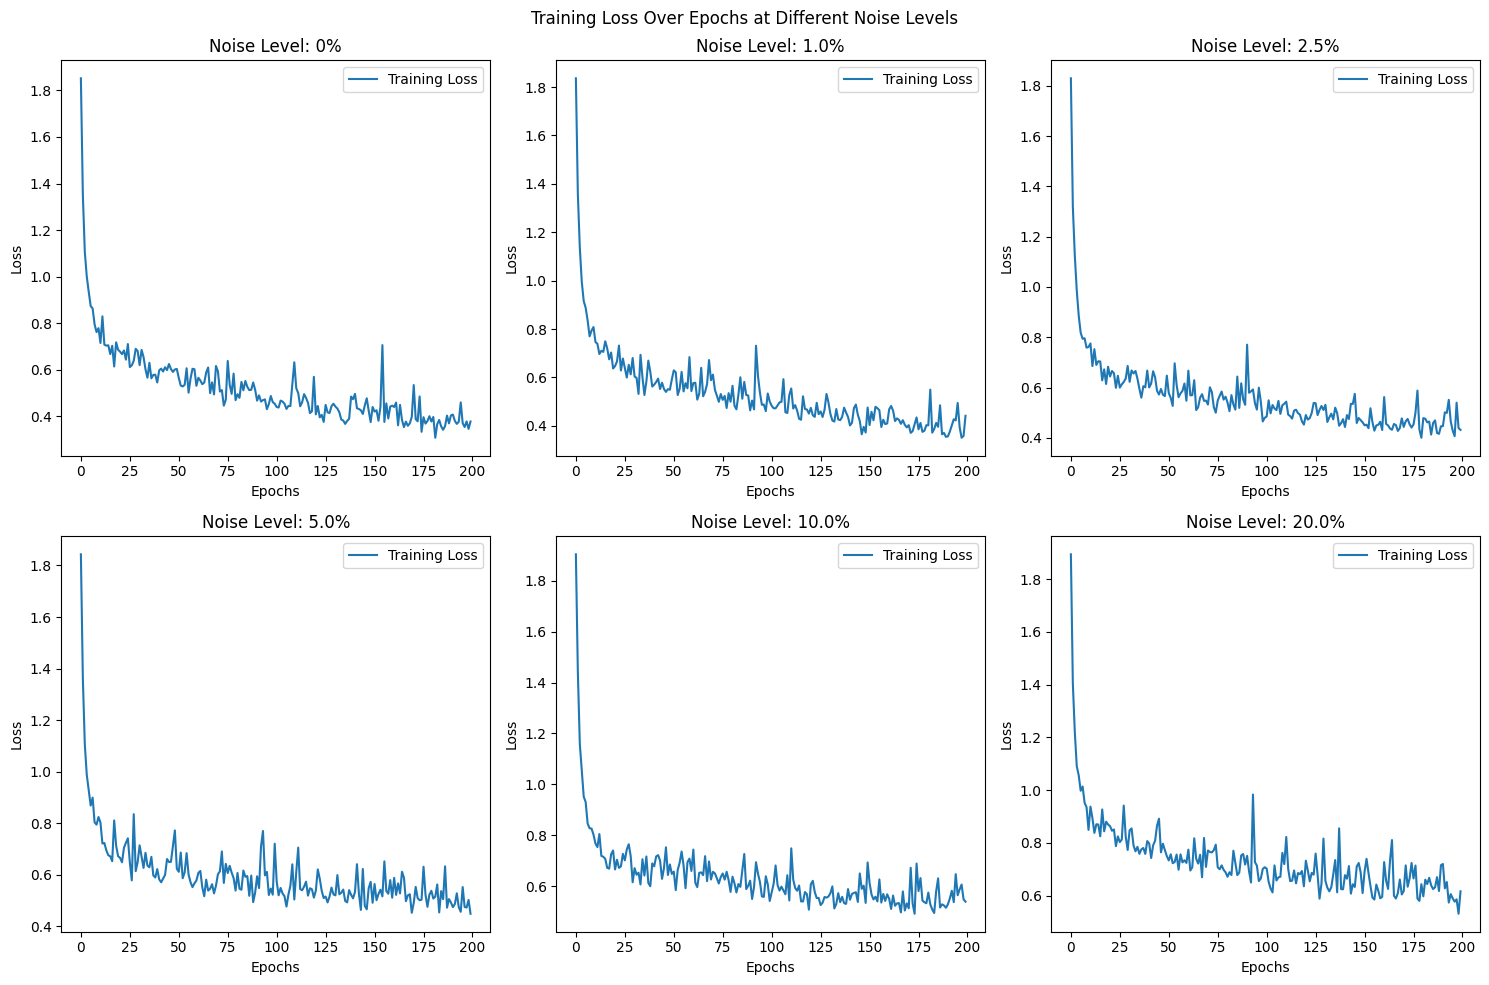

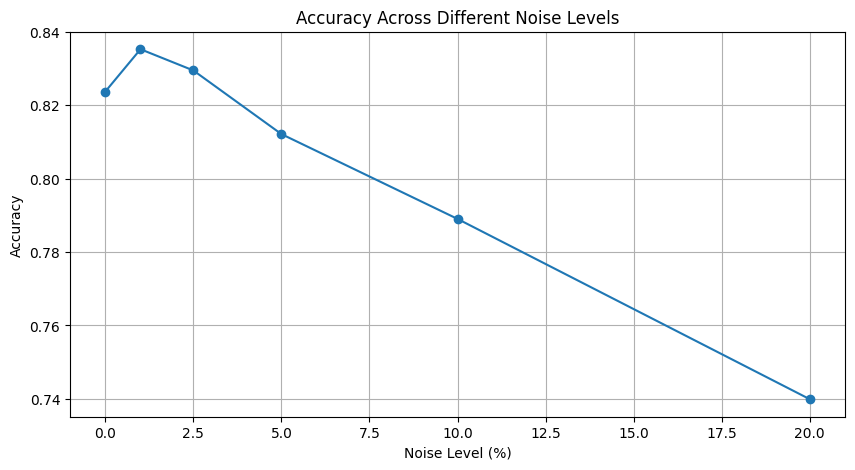

In [300]:
# Set up for plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Training Loss Over Epochs at Different Noise Levels")

# Evaluate accuracy
accuracies = []

# Training and plotting
for i, X_train_scaled in enumerate(X_train_scaled_list):
    # Initialize the model for each noise level
    model = EnhancedNNClassifier(
         num_classes=len(np.unique(y))
    ).to(device)
    # use SGD
    # optimizer = optim.SGD(model.parameters(), lr=0.001)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Prepare DataLoader
    train_loader = numpy_to_tensor(X_train_scaled, y_train, device=device)

    # Train the model and capture training losses
    train_losses = train_model(
        model, train_loader, optimizer, criterion, epochs=200
    )

    # Calculate accuracy
    accuracy = calculate_accuracy(model, test_loader)
    accuracies.append(accuracy)

    # Plotting the training losses
    ax = axs[i // 3, i % 3]
    ax.plot(train_losses, label="Training Loss")
    ax.set_title(f"Noise Level: {noise_levels[i]*100}%")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()


plt.tight_layout()
plt.show()


# Plot accuracies across different noise levels
plt.figure(figsize=(10, 5))
plt.plot([n * 100 for n in noise_levels], accuracies, marker="o")
plt.title("Accuracy Across Different Noise Levels")
plt.xlabel("Noise Level (%)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [301]:
# Display all accuracies
for noise, acc in zip(noise_levels, accuracies):
    print(f"Accuracy at {noise*100}% noise: {acc:.4f}")

Accuracy at 0% noise: 0.8237
Accuracy at 1.0% noise: 0.8353
Accuracy at 2.5% noise: 0.8295
Accuracy at 5.0% noise: 0.8121
Accuracy at 10.0% noise: 0.7890
Accuracy at 20.0% noise: 0.7399


In [302]:
# Function to add noise to data
def add_noise(X, noise_percent):
    std_devs = X.std(axis=0)
    noise = np.random.normal(0, std_devs, X.shape) * noise_percent
    X_noisy = X + noise
    return X_noisy


# Function to add noise to data
noise_levels = [0, 0.05, 0.1, 0.2, 0.5, 0.99]

In [303]:
X_noisy = [add_noise(X_train, noise) for noise in noise_levels]